<h2>1. Data Loading and Preprocessing</h2>

In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ucimlrepo import fetch_ucirepo

from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    precision_score,
    recall_score,
    f1_score,
    matthews_corrcoef
)

import pickle
import os



In [93]:
#fetching the dataset
dataset = fetch_ucirepo(id=222)

#loading the dataset into a pandas dataframe
X = dataset.data.features
y = dataset.data.targets

# metadata
print("Metadata:", dataset.metadata)

# variable information
vars_df = dataset.variables.sort_values(by="role")
print("Variables:\n", vars_df.to_string(index=False))


Metadata: {'uci_id': 222, 'name': 'Bank Marketing', 'repository_url': 'https://archive.ics.uci.edu/dataset/222/bank+marketing', 'data_url': 'https://archive.ics.uci.edu/static/public/222/data.csv', 'abstract': 'The data is related with direct marketing campaigns (phone calls) of a Portuguese banking institution. The classification goal is to predict if the client will subscribe a term deposit (variable y).', 'area': 'Business', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 45211, 'num_features': 16, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Age', 'Occupation', 'Marital Status', 'Education Level'], 'target_col': ['y'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 2014, 'last_updated': 'Fri Aug 18 2023', 'dataset_doi': '10.24432/C5K306', 'creators': ['S. Moro', 'P. Rita', 'P. Cortez'], 'intro_paper': {'ID': 277, 'type': 'NATIVE', 'title': 'A data-driven approach to pre

In [94]:
X.head(10)

,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,month,duration,campaign,pdays,previous,poutcome
0,58,management,married,tertiary,no,2143,yes,no,NaN,5,may,261,1,-1,0,NaN
1,44,technician,single,secondary,no,29,yes,no,NaN,5,may,151,1,-1,0,NaN
2,33,entrepreneur,married,secondary,no,2,yes,yes,NaN,5,may,76,1,-1,0,NaN
3,47,blue-collar,married,NaN,no,1506,yes,no,NaN,5,may,92,1,-1,0,NaN
4,33,NaN,single,NaN,no,1,no,no,NaN,5,may,198,1,-1,0,NaN
5,35,management,married,tertiary,no,231,yes,no,NaN,5,may,139,1,-1,0,NaN
6,28,management,single,tertiary,no,447,yes,yes,NaN,5,may,217,1,-1,0,NaN
7,42,entrepreneur,divorced,tertiary,yes,2,yes,no,NaN,5,may,380,1,-1,0,NaN
8,58,retired,married,primary,no,121,yes,no,NaN,5,may,50,1,-1,0,NaN
9,43,technician,single,secondary,no,593,yes,no,NaN,5,may,55,1,-1,0,NaN


In [95]:
# Convert target DataFrame to Series
y = y.iloc[:, 0]

# Encode target
y = y.map({'no': 0, 'yes': 1})


In [96]:
print(f"Total samples: {X.shape[0]}")
print(f"Total features: {X.shape[1]}")
print(f"Target classes:\n{y.value_counts()}")

Total samples: 45211
Total features: 16
Target classes:
y
0    39922
1     5289
Name: count, dtype: int64


Identifying Categorical and Numerical Columns

In [97]:
# Features already in X
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(exclude=['object']).columns.tolist()

print("Categorical:", categorical_cols)
print("Numerical:", numerical_cols)


Categorical: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']
Numerical: ['age', 'balance', 'day_of_week', 'duration', 'campaign', 'pdays', 'previous']


C:\Users\Personal\AppData\Local\Temp\ipykernel_31144\582106784.py:2: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.
  categorical_cols = X.select_dtypes(include=['object']).columns.tolist()


Handling Null Data

In [98]:
print(X.isnull().sum())

age                0
job              288
marital            0
education       1857
default            0
balance            0
housing            0
loan               0
contact        13020
day_of_week        0
month              0
duration           0
campaign           0
pdays              0
previous           0
poutcome       36959
dtype: int64


In [99]:
missing_cols = X.columns[X.isnull().any()].tolist()
print(missing_cols)

['job', 'education', 'contact', 'poutcome']


In [100]:
# Fill missing values with "unknown" as all of them are categorical
X[missing_cols] = X[missing_cols].fillna("unknown")

Understanding data (Visualisations)

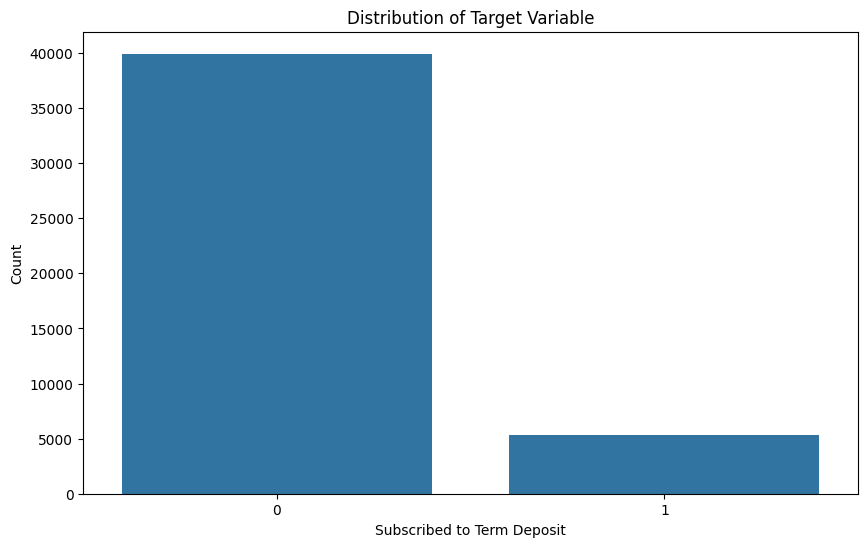

In [101]:
plt.figure(figsize=(10, 6))
sns.countplot(x=y)
plt.title("Distribution of Target Variable")
plt.xlabel("Subscribed to Term Deposit")
plt.ylabel("Count")
plt.show()

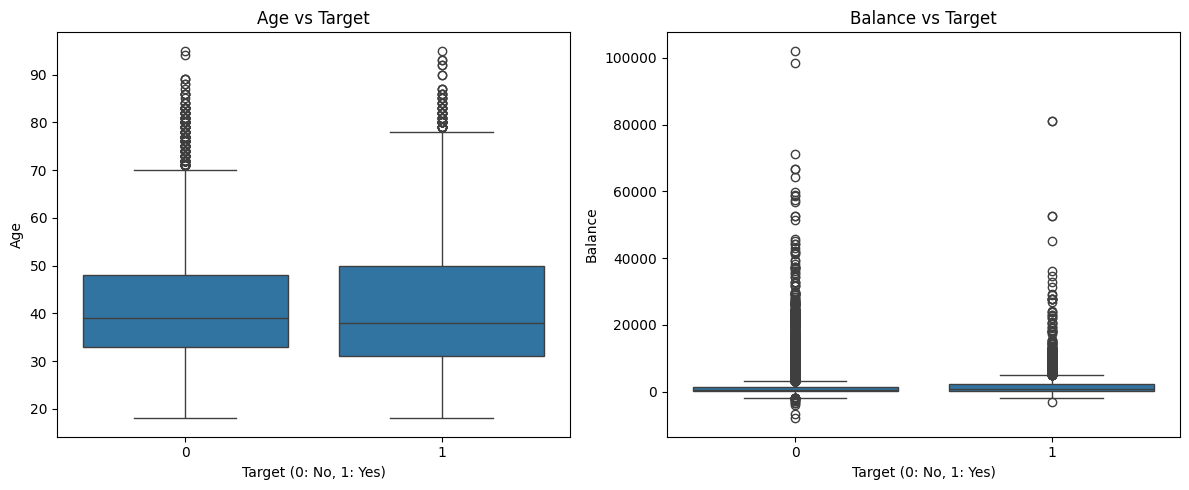

In [102]:
# Plot numerical features against target
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Age vs Target
sns.boxplot(x=y, y=X['age'], ax=axes[0])
axes[0].set_title('Age vs Target')
axes[0].set_xlabel('Target (0: No, 1: Yes)')
axes[0].set_ylabel('Age')

# Balance vs Target
sns.boxplot(x=y, y=X['balance'], ax=axes[1])
axes[1].set_title('Balance vs Target')
axes[1].set_xlabel('Target (0: No, 1: Yes)')
axes[1].set_ylabel('Balance')

plt.tight_layout()
plt.show()

Train-Test Split

In [103]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

Applying Preprocessing Steps to Train and Test Sets

In [104]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_cols),
    ]
)

X_train_processed = preprocessor.fit_transform(X_train)


In [105]:
os.makedirs("model", exist_ok=True)

with open("model/preprocessor.pkl", "wb") as f:
    pickle.dump(preprocessor, f)

print("Preprocessor saved successfully.")

Preprocessor saved successfully.


In [106]:
X_test_processed = preprocessor.transform(X_test)

print(X_train_processed.shape)
print(X_test_processed.shape)


(36168, 51)
(9043, 51)


<h2>2. Model Training and Evaluation</h2>

In [107]:
def evaluate_and_save_model(
    model,
    model_name,
    X_train,
    X_test,
    y_train,
    y_test,
    results_dict,
    save_dir="model"
):
    """
    Trains a model, evaluates it, stores metrics, and saves the model as a pickle file.
    """

    # Create directory if it doesn't exist
    os.makedirs(save_dir, exist_ok=True)

    # Train model
    model.fit(X_train, y_train)

    # Predictions
    y_pred = model.predict(X_test)

    # Probabilities for AUC
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_prob)
    else:
        y_prob = None
        auc = None

    # Store metrics
    results_dict[model_name] = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "AUC": auc,
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred),
        "MCC": matthews_corrcoef(y_test, y_pred)
    }

    # Save model as pickle
    file_path = os.path.join(
        save_dir,
        model_name.lower().replace(" ", "_") + ".pkl"
    )

    with open(file_path, "wb") as f:
        pickle.dump(model, f)

    print(f"Saved model: {file_path}")

    return y_pred, y_prob


results = {}


Applying Logistic Regression

In [108]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=1000, random_state=42)

y_pred_lr, y_prob_lr = evaluate_and_save_model(
    model=lr,
    model_name="Logistic Regression",
    X_train=X_train_processed,
    X_test=X_test_processed,
    y_train=y_train,
    y_test=y_test,
    results_dict=results
)

results

Saved model: model\logistic_regression.pkl


{'Logistic Regression': {'Accuracy': 0.901249585314608,
  'AUC': 0.9055740146044154,
  'Precision': 0.6444833625218914,
  'Recall': 0.34782608695652173,
  'F1': 0.4518109269490485,
  'MCC': 0.42605817794513523}}

In [109]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=42)

y_pred_dt, y_prob_dt = evaluate_and_save_model(
    model=dt,
    model_name="Decision Tree",
    X_train=X_train_processed,
    X_test=X_test_processed,
    y_train=y_train,
    y_test=y_test,
    results_dict=results
)

results

Saved model: model\decision_tree.pkl


{'Logistic Regression': {'Accuracy': 0.901249585314608,
  'AUC': 0.9055740146044154,
  'Precision': 0.6444833625218914,
  'Recall': 0.34782608695652173,
  'F1': 0.4518109269490485,
  'MCC': 0.42605817794513523},
 'Decision Tree': {'Accuracy': 0.8745991374543846,
  'AUC': 0.7014571863832587,
  'Precision': 0.46487985212569316,
  'Recall': 0.47542533081285443,
  'F1': 0.4700934579439252,
  'MCC': 0.39902087033749317}}

In [110]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)

y_pred_knn, y_prob_knn = evaluate_and_save_model(
    model=knn,
    model_name="K-Nearest Neighbors",
    X_train=X_train_processed,
    X_test=X_test_processed,
    y_train=y_train,
    y_test=y_test,
    results_dict=results
)

results

Saved model: model\k-nearest_neighbors.pkl


{'Logistic Regression': {'Accuracy': 0.901249585314608,
  'AUC': 0.9055740146044154,
  'Precision': 0.6444833625218914,
  'Recall': 0.34782608695652173,
  'F1': 0.4518109269490485,
  'MCC': 0.42605817794513523},
 'Decision Tree': {'Accuracy': 0.8745991374543846,
  'AUC': 0.7014571863832587,
  'Precision': 0.46487985212569316,
  'Recall': 0.47542533081285443,
  'F1': 0.4700934579439252,
  'MCC': 0.39902087033749317},
 'K-Nearest Neighbors': {'Accuracy': 0.8961627778392126,
  'AUC': 0.8277209275898927,
  'Precision': 0.5990016638935108,
  'Recall': 0.34026465028355385,
  'F1': 0.43399638336347196,
  'MCC': 0.40012752249162636}}

In [111]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()

y_pred_nb, y_prob_nb = evaluate_and_save_model(
    model=nb,
    model_name="Naive Bayes",
    X_train=X_train_processed,
    X_test=X_test_processed,
    y_train=y_train,
    y_test=y_test,
    results_dict=results
)

results

Saved model: model\naive_bayes.pkl


{'Logistic Regression': {'Accuracy': 0.901249585314608,
  'AUC': 0.9055740146044154,
  'Precision': 0.6444833625218914,
  'Recall': 0.34782608695652173,
  'F1': 0.4518109269490485,
  'MCC': 0.42605817794513523},
 'Decision Tree': {'Accuracy': 0.8745991374543846,
  'AUC': 0.7014571863832587,
  'Precision': 0.46487985212569316,
  'Recall': 0.47542533081285443,
  'F1': 0.4700934579439252,
  'MCC': 0.39902087033749317},
 'K-Nearest Neighbors': {'Accuracy': 0.8961627778392126,
  'AUC': 0.8277209275898927,
  'Precision': 0.5990016638935108,
  'Recall': 0.34026465028355385,
  'F1': 0.43399638336347196,
  'MCC': 0.40012752249162636},
 'Naive Bayes': {'Accuracy': 0.8548048214088245,
  'AUC': 0.8100945416322902,
  'Precision': 0.4059040590405904,
  'Recall': 0.5198487712665406,
  'F1': 0.45586406962287607,
  'MCC': 0.37735837569864067}}

In [112]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42)

y_pred_rf, y_prob_rf = evaluate_and_save_model(
    model=rf,
    model_name="Random Forest",
    X_train=X_train_processed,
    X_test=X_test_processed,
    y_train=y_train,
    y_test=y_test,
    results_dict=results
)

results

Saved model: model\random_forest.pkl


{'Logistic Regression': {'Accuracy': 0.901249585314608,
  'AUC': 0.9055740146044154,
  'Precision': 0.6444833625218914,
  'Recall': 0.34782608695652173,
  'F1': 0.4518109269490485,
  'MCC': 0.42605817794513523},
 'Decision Tree': {'Accuracy': 0.8745991374543846,
  'AUC': 0.7014571863832587,
  'Precision': 0.46487985212569316,
  'Recall': 0.47542533081285443,
  'F1': 0.4700934579439252,
  'MCC': 0.39902087033749317},
 'K-Nearest Neighbors': {'Accuracy': 0.8961627778392126,
  'AUC': 0.8277209275898927,
  'Precision': 0.5990016638935108,
  'Recall': 0.34026465028355385,
  'F1': 0.43399638336347196,
  'MCC': 0.40012752249162636},
 'Naive Bayes': {'Accuracy': 0.8548048214088245,
  'AUC': 0.8100945416322902,
  'Precision': 0.4059040590405904,
  'Recall': 0.5198487712665406,
  'F1': 0.45586406962287607,
  'MCC': 0.37735837569864067},
 'Random Forest': {'Accuracy': 0.9044564856795311,
  'AUC': 0.926285639543899,
  'Precision': 0.6506211180124224,
  'Recall': 0.3960302457466919,
  'F1': 0.49236

In [113]:
from xgboost import XGBClassifier

xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

y_pred_xgb, y_prob_xgb = evaluate_and_save_model(
    model=xgb,
    model_name="XGBoost",
    X_train=X_train_processed,
    X_test=X_test_processed,
    y_train=y_train,
    y_test=y_test,
    results_dict=results
)

results

c:\Users\Personal\Dev\learning\ML\ML_Assignment_2\ml_assignment_2\.venv_ml2\Lib\site-packages\xgboost\training.py:199: UserWarning: [14:56:31] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Saved model: model\xgboost.pkl


{'Logistic Regression': {'Accuracy': 0.901249585314608,
  'AUC': 0.9055740146044154,
  'Precision': 0.6444833625218914,
  'Recall': 0.34782608695652173,
  'F1': 0.4518109269490485,
  'MCC': 0.42605817794513523},
 'Decision Tree': {'Accuracy': 0.8745991374543846,
  'AUC': 0.7014571863832587,
  'Precision': 0.46487985212569316,
  'Recall': 0.47542533081285443,
  'F1': 0.4700934579439252,
  'MCC': 0.39902087033749317},
 'K-Nearest Neighbors': {'Accuracy': 0.8961627778392126,
  'AUC': 0.8277209275898927,
  'Precision': 0.5990016638935108,
  'Recall': 0.34026465028355385,
  'F1': 0.43399638336347196,
  'MCC': 0.40012752249162636},
 'Naive Bayes': {'Accuracy': 0.8548048214088245,
  'AUC': 0.8100945416322902,
  'Precision': 0.4059040590405904,
  'Recall': 0.5198487712665406,
  'F1': 0.45586406962287607,
  'MCC': 0.37735837569864067},
 'Random Forest': {'Accuracy': 0.9044564856795311,
  'AUC': 0.926285639543899,
  'Precision': 0.6506211180124224,
  'Recall': 0.3960302457466919,
  'F1': 0.49236

Converting results to a DataFrame

In [114]:
results_df = pd.DataFrame(results).T
print(results_df)

                     Accuracy       AUC  Precision    Recall        F1  \
Logistic Regression  0.901250  0.905574   0.644483  0.347826  0.451811   
Decision Tree        0.874599  0.701457   0.464880  0.475425  0.470093   
K-Nearest Neighbors  0.896163  0.827721   0.599002  0.340265  0.433996   
Naive Bayes          0.854805  0.810095   0.405904  0.519849  0.455864   
Random Forest        0.904456  0.926286   0.650621  0.396030  0.492362   
XGBoost              0.905452  0.928747   0.626717  0.474480  0.540075   

                          MCC  
Logistic Regression  0.426058  
Decision Tree        0.399021  
K-Nearest Neighbors  0.400128  
Naive Bayes          0.377358  
Random Forest        0.459724  
XGBoost              0.494383  


In [115]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(
    y_true,
    y_pred,
    model_name,
    labels=["No", "Yes"]
):
    """
    Plots a confusion matrix using seaborn heatmap.

    Parameters:
    - y_true: true labels
    - y_pred: predicted labels
    - model_name: name of the model (string)
    - labels: class labels for display
    """

    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(5, 4))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=labels,
        yticklabels=labels
    )
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.tight_layout()
    plt.show()


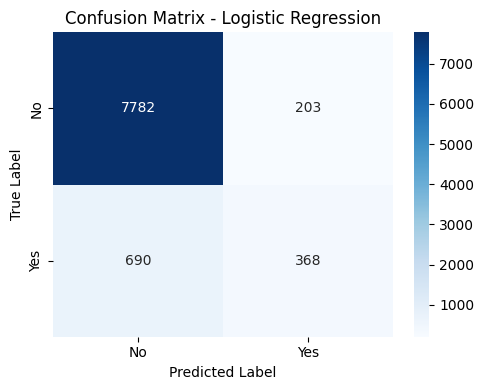

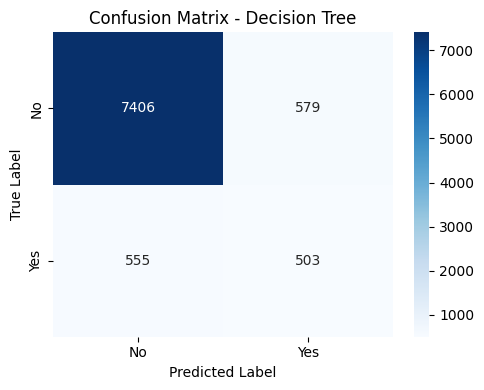

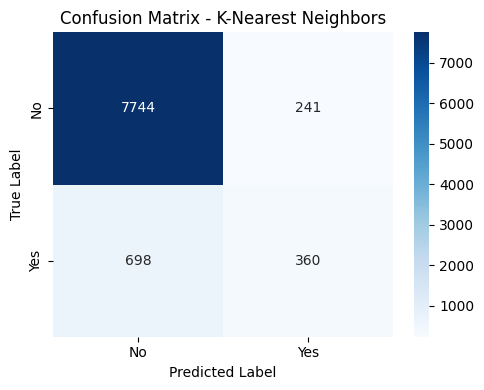

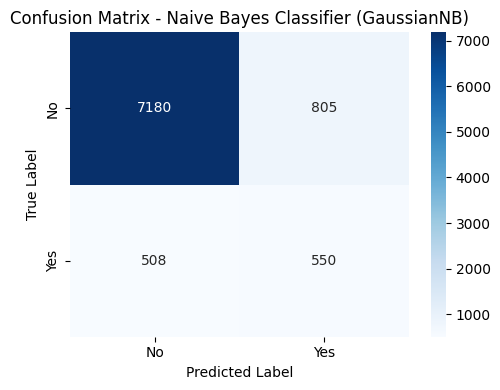

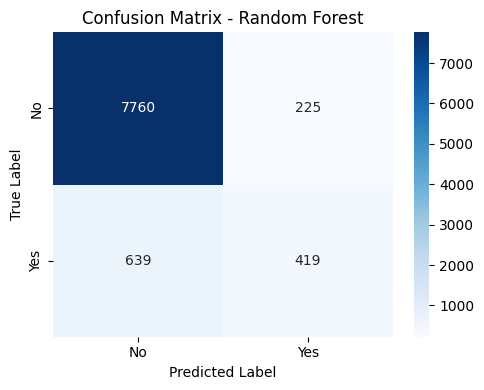

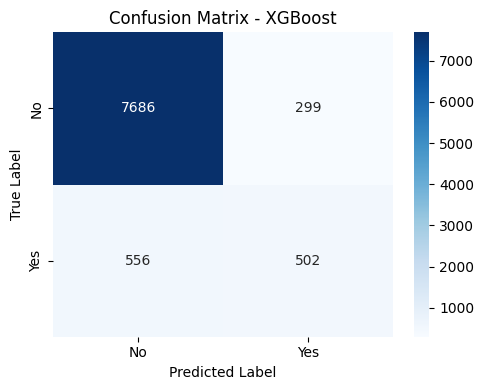

In [116]:
plot_confusion_matrix(
    y_true=y_test,
    y_pred=y_pred_lr,
    model_name="Logistic Regression"
)

plot_confusion_matrix(
    y_true=y_test,
    y_pred=y_pred_dt,
    model_name="Decision Tree"
)

plot_confusion_matrix(
    y_true=y_test,
    y_pred=y_pred_knn,
    model_name="K-Nearest Neighbors"
)

plot_confusion_matrix(
    y_true=y_test,
    y_pred=y_pred_nb,
    model_name="Naive Bayes Classifier (GaussianNB)"
)

plot_confusion_matrix(
    y_true=y_test,
    y_pred=y_pred_rf,
    model_name="Random Forest"
)

plot_confusion_matrix(
    y_true=y_test,
    y_pred=y_pred_xgb,
    model_name="XGBoost"
)

In [118]:
# After train-test split
test_df = X_test.copy()
test_df["y"] = y_test.values

test_df.to_csv("test_data.csv", index=False)
